### Execution Plans and the effect of Caching
Unlike a regular pythong program, map/reduce commands do not always perform any computation when they are executed. Instead, they construct something called an **execution plan**. Only when a result is needed does the computation start. This approach is also called **lazy execution**.

The benefit from lazy execution is in minimizing the the number of memory accesses. Consider for example the following map/reduce commands:
```python
A=RDD.map(lambda x:x*x).filter(lambda x: x%2==0)
A.reduce(lambda x,y:x+y) 
```

The commands defines the following plan. For each number `x` in the RDD:
1. Compute the square of `x`
2. Filter out `x*x` whose value is odd.
3. Sum the elements that were not filtered out.

A naive execution plan is to square all items in the RDD, store the results in a new RDD, then perform a filtering pass, generating a second RDD,  and finally perform the summation. Doing this will require iterating through the RDD three times, and creating 2 interim RDDs. As memory access is the bottleneck in this type of computation, the execution plan is slow.

A better execution plan is to perform all three operations on each element of the RDD in sequence, and then move to the next element. This plan is faster because we iterate through the elements of the RDD only once, and because we don't need to save the intermediate results. We need to maintain only one variable: the partial sum, and as that is a single variable, we can use a CPU register.

#### The `time()` method and the `%%time` magic
The `time` method returns the value of the system clock. We will use t_start and t_end later on to find the relevant lines in log files.

the `%%time` command is a *cell magic* which measures the execution time of the cell. We will mostly be interested in the wall time, which includes the time it takes to move data in the memory hierarchy.

([More on ipython magics](https://ipython.org/ipython-doc/3/interactive/magics.html))

### Preparations
In the following cells we set t_start, create an RDD, and define a function which wastes some time and then returns `cos(i)`.

In [1]:
%%time
from time import time
t_start=time()
print 'setting t_start to',t_start

setting t_start to 1458702382.1
CPU times: user 270 µs, sys: 151 µs, total: 421 µs
Wall time: 279 µs


In [2]:
%%time
# create an RDD with one million elements.
RDD=sc.parallelize(range(10000000))

CPU times: user 641 ms, sys: 214 ms, total: 855 ms
Wall time: 1.29 s


In [3]:
from math import cos
def taketime(i):
    [cos(j) for j in range(10)]
    return cos(i)

In [4]:
%%time
taketime(5)

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 15 µs


0.2836621854632263

### Cascading operations

In [5]:
%%time
Interm=RDD.map(lambda x: taketime(x))

CPU times: user 25 µs, sys: 15 µs, total: 40 µs
Wall time: 44.8 µs


#### Execution plan
At the point of definition no computation is done, which is why the operation takes only 20 micro-seconds (Wall Time).
At this point the variable `Interm` does not point to an actual data structure. Instead, it points to an **execution plan** which defines the **dependence graph** which defines the dependence of the to-be-created RDD on other RDDs.

The first line corresponds to `Interm` and the second line corresponds to `RDD` which is the input to interm
```
(2) PythonRDD[8] at RDD at PythonRDD.scala:43 []
 |  ParallelCollectionRDD[4] at parallelize at PythonRDD.scala:423 []
```

In [6]:
print Interm.toDebugString()

(2) PythonRDD[1] at RDD at PythonRDD.scala:43 []
 |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:423 []


#### Actual execution
The `reduce` command needs to output an actual output, **spark** therefor has to actually execute the `map` and the `reduce`. Some real computation needs to be done, which takes about 1.78 seconds (Wall time).

In [7]:
%%time
print 'out=',Interm.reduce(lambda x,y:x+y)

out= 1.33853897901
CPU times: user 8.99 ms, sys: 4.34 ms, total: 13.3 ms
Wall time: 19 s


#### Executing a different calculation based on the same plan.
The plan defined by `Interm` can be executed many times. Below we give an example. 

**Note:** the run-time is similar to that of the previous command because the intermediate results that are due to `Interm` have not been saved in memory.

In [8]:
%%time
print 'out=',Interm.filter(lambda x:x>0).count()

out= 5000001
CPU times: user 9.93 ms, sys: 4.01 ms, total: 13.9 ms
Wall time: 17.1 s


#### Caching intermediate results
The computation above is wasteful because each time we recompute the `map` operation.

We sometimes want to keep the intermediate results in memory so that we can reuse them without recalculating them. This will reduce the running time, at the cost of requiring more memory.

The method `cache()` indicates that the RDD generates in this plan should be stored in memory. Note that this is still only a *plan*. The actual calculation will be done only when the final result is seeked.

In [9]:
%%time
Interm=RDD.map(lambda x: taketime(x)).cache()

CPU times: user 3.04 ms, sys: 1.18 ms, total: 4.23 ms
Wall time: 7.6 ms


#### Plan to cache
The definition of `Interm` is almost the same as before. However, the *plan* corresponding to `Interm` is more elaborate and contains information about how the intermediate results will be chached and partitioned.

In [10]:
print Interm.toDebugString()

(2) PythonRDD[4] at RDD at PythonRDD.scala:43 [Memory Serialized 1x Replicated]
 |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:423 [Memory Serialized 1x Replicated]


#### Creating the cache
The following command executes the first map-reduce command **and** caches the result of the `map` command in memory. 

In [11]:
%%time
print 'out=',Interm.reduce(lambda x,y:x+y)

out= 1.33853897901
CPU times: user 5.84 ms, sys: 3.02 ms, total: 8.86 ms
Wall time: 19.5 s


#### Using the cache
The second use of `Interm` is much faster than when we did not use `cache`: 185 ms instead of 1800 ms.

In [12]:
%%time
print 'out=',Interm.filter(lambda x:x>0).count()

out= 5000001
CPU times: user 7.19 ms, sys: 2.75 ms, total: 9.93 ms
Wall time: 1.7 s


In [13]:
t_end=time()
print 't_end=',t_end

t_end= 1458702153.99


### Read the logs

To get more insight into the memory consumption of our code examples we use the log files.

In [14]:
from combineLogs import combineLogs
df=combineLogs(t_start,t_end)

In [15]:
df.shape

(1085, 26)

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
df.columns

Index([u'driver.BlockManager.disk.diskSpaceUsed_MB.value',
       u'driver.BlockManager.memory.maxMem_MB.value',
       u'driver.BlockManager.memory.memUsed_MB.value',
       u'driver.BlockManager.memory.remainingMem_MB.value',
       u'driver.DAGScheduler.job.activeJobs.value',
       u'driver.DAGScheduler.job.allJobs.value',
       u'driver.DAGScheduler.messageProcessingTime.count',
       u'driver.DAGScheduler.messageProcessingTime.duration_unit',
       u'driver.DAGScheduler.messageProcessingTime.m15_rate',
       u'driver.DAGScheduler.messageProcessingTime.m1_rate',
       u'driver.DAGScheduler.messageProcessingTime.m5_rate',
       u'driver.DAGScheduler.messageProcessingTime.max',
       u'driver.DAGScheduler.messageProcessingTime.mean',
       u'driver.DAGScheduler.messageProcessingTime.mean_rate',
       u'driver.DAGScheduler.messageProcessingTime.min',
       u'driver.DAGScheduler.messageProcessingTime.p50',
       u'driver.DAGScheduler.messageProcessingTime.p75',
       u'dri

In [18]:
#cols=[name for name in df.columns if ('messageProcessing' in name) and ('rate' in name)]
cols=[u'driver.BlockManager.memory.maxMem_MB.value',\
       u'driver.BlockManager.memory.memUsed_MB.value'] #,\
#       u'driver.BlockManager.memory.remainingMem_MB.value']
cols

[u'driver.BlockManager.memory.maxMem_MB.value',
 u'driver.BlockManager.memory.memUsed_MB.value']

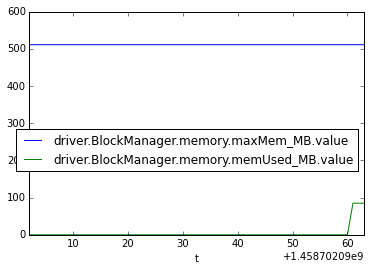

In [19]:
f = plt.figure()

df[cols].plot(ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()